In [1]:
import copy
import logging
from pathlib import Path
import shutil

import amici
from amici.petab_import import import_petab_problem
from amici.plotting import plotObservableTrajectories
import matplotlib.pyplot as plt
from more_itertools import one
import numpy as np
import pandas as pd
import petab
from petab.C import (
    TIME,
    ESTIMATE,
    MEASUREMENT,
    NOMINAL_VALUE,
)
import yaml2sbml

# Optimization
import pypesto.engine
import pypesto.objective
import pypesto.optimize
import pypesto.petab
import pypesto.visualize

# Optimal control
import petab_control
import petab_control.problem
from petab_control.constants import (
    CONTROL_TIMECOURSE_ID,
    PERIODS_RESULTS,
)
from petab_control.problem import (
    LLH,
    SLLH,
    get_control_petab_problem,
)

# Timecourse
import petab_timecourse
from petab_timecourse import Timecourse

# Helpers
def plot(
    rdata,
    model,
    estimate_petab_problem,
    control_petab_problem = None,
):
    fig, ax = plt.subplots()
    ax.scatter(
        estimate_petab_problem.measurement_df[petab.C.TIME],
        estimate_petab_problem.measurement_df[petab.C.MEASUREMENT],
        label='Real measurements for fitting.',
        color='blue',
    )

    if control_petab_problem is not None:
        ax.scatter(
            control_petab_problem.measurement_df[petab.C.TIME],
            control_petab_problem.measurement_df[petab.C.MEASUREMENT],
            label='Target measurements for control.',
            color='orange',
        )

    plotObservableTrajectories(rdata, model=model, ax=ax)
    ax.axvspan(0, 20, facecolor='blue', alpha=0.1)
    ax.axvspan(20, 100, facecolor='orange', alpha=0.1)
    ax.set_ylim(0,1)
    return ax, rdata

# Plotted time
end_time = 100


# The same optimizer, optimization engine, and number of starts is
# used for both estimation and optimal control, for this toy model.
optimizer = pypesto.optimize.FidesOptimizer(verbose=logging.WARNING)
#engine = pypesto.engine.MultiProcessEngine()
engine = pypesto.engine.SingleCoreEngine()

n_starts = 8

In [2]:
# Setup PEtab problem
input_path = Path('input') / 'optimize_then_control'
output_path = Path('output') / 'optimize_then_control'
petab_output_path = output_path / 'petab'
petab_output_path.mkdir(parents=True, exist_ok=True)

#if not petab_output_path.exists():
if True:
    shutil.rmtree(petab_output_path)
    shutil.copytree(input_path / 'petab', petab_output_path)
    yaml2sbml.yaml2sbml(
        str(input_path / 'model.yaml'),
        str(petab_output_path / 'estimate' / 'model.xml'),
    )

estimate_petab_problem = petab_timecourse.Problem.from_yaml(
    petab_output_path / 'estimate' / 'petab_problem.yaml',
    timecourse_file=petab_output_path / 'estimate' / 'timecourse.tsv',
)

# Optimize estimate problem to estimate patient-specific parameters
## Setup
model_output_path = output_path / 'models'
estimate_model_output_path = model_output_path / 'estimate'

In [3]:
# Setup PEtab control problem
control_petab_output_path = output_path / 'control_petab'
control_petab_output_path.mkdir(parents=True, exist_ok=True)

control_problem = petab_control.Problem.from_yaml(
    yaml_path=input_path / 'petab' / 'control' / 'petab_control_problem.yaml',
)

In [4]:
control_petab_problem = get_control_petab_problem(
    petab_control_problem=control_problem,
    petab_problem=estimate_petab_problem,
    timecourse_id='timecourse1',
)

In [5]:
from petab_timecourse.amici import collect_x, collect_sx, collect_t, remove_duplicates

from petab_timecourse.simulator import AmiciSimulator

model_settings = {
    'setAlwaysCheckFinite': True,
}

solver_settings = {
    'setAbsoluteTolerance': 1e-8,
    'setRelativeTolerance': 1e-6,
    'setSensitivityOrder': amici.SensitivityOrder.first,
    'setSensitivityMethod': amici.SensitivityMethod.forward,
}

estimated_parameters = {
    'decay': 0.010658565449186457,
    'substrate0': 0.8109781420306815,
}

# FIXME use result from optimizing original problem
estimated_parameters = {
    'decay': 1.0,
    'substrate0': 0.8109781420306815,
}

default_problem_parameters = {
    **estimated_parameters,
    'influx': 0.1,
}

In [6]:
estimated_petab_problem = copy.deepcopy(estimate_petab_problem)
estimated_petab_problem.parameter_df[ESTIMATE] = 0

setup_simulator_kwargs = {
    'simulator_class': AmiciSimulator,
    'petab_problem': estimate_petab_problem,
    'timecourse_id': 'timecourse1',
    'default_problem_parameters': default_problem_parameters,
    'model_settings': model_settings,
    'solver_settings': solver_settings,
    'fix_petab_problem_parameters': estimated_parameters,
}

control_model_output_path = model_output_path / 'control'

petab_importer_kwargs = {
    'output_folder': str(control_model_output_path),
    'validate_petab': False,
}

create_problem_kwargs = {
    'copy_objective': False,
}

In [7]:
Timecourse.from_df(
    timecourse_df=estimate_petab_problem.timecourse_df,
    timecourse_id='timecourse1',
).periods

In [8]:
pypesto_problem = petab_control.objective.get_pypesto_problem(
    petab_control_problem=control_problem,
    setup_simulator_kwargs=setup_simulator_kwargs,
    petab_importer_kwargs=petab_importer_kwargs,
)

In [9]:
solver_settings = {
    #'setAbsoluteTolerance': 1e-8,
    #'setRelativeTolerance': 1e-6,
}

for setting, value in solver_settings.items():
    getattr(control_problem.simulator.amici_solver, setting)(value)

In [10]:
history_options = pypesto.objective.HistoryOptions(
    trace_record=True,
)

pypesto_result = pypesto.optimize.minimize(
    problem=pypesto_problem,
    n_starts=10,
    optimizer=optimizer,
    history_options=history_options,
    filename=None,
)

  0%|          | 0/10 [00:00<?, ?it/s]WARNING:root:Fides is using BFGS as hessian approximation, as the problem does not provide a Hessian. Specify a Hessian to use a more efficient hybrid approximation scheme.
2022-06-01 14:24:05 fides(WARNING) Stopping as function difference 2.84E-14 was smaller than specified tolerances (atol=1.00E-08, rtol=1.00E-08)
 10%|█         | 1/10 [00:01<00:17,  1.93s/it]WARNING:root:Fides is using BFGS as hessian approximation, as the problem does not provide a Hessian. Specify a Hessian to use a more efficient hybrid approximation scheme.
2022-06-01 14:24:11 fides(WARNING) Stopping as function difference 3.55E-15 was smaller than specified tolerances (atol=1.00E-08, rtol=1.00E-08)
 20%|██        | 2/10 [00:07<00:32,  4.09s/it]WARNING:root:Fides is using BFGS as hessian approximation, as the problem does not provide a Hessian. Specify a Hessian to use a more efficient hybrid approximation scheme.
2022-06-01 14:24:14 fides(WARNING) Stopping as trust region r

In [11]:
pypesto_result.optimize_result.list[0]

{'id': '4',
 'x': array([ 1.        ,  0.81097814, -1.        , -0.29986387,  0.81402973,
         0.69897   , -0.31225298]),
 'fval': 18.44249676496477,
 'grad': array([            nan,             nan,             nan, -7.56077410e-06,
        -5.99282449e-03,             nan,  2.43683892e-03]),
 'hess': array([[            nan,             nan,             nan,
                     nan,             nan,             nan,
                     nan],
        [            nan,             nan,             nan,
                     nan,             nan,             nan,
                     nan],
        [            nan,             nan,             nan,
                     nan,             nan,             nan,
                     nan],
        [            nan,             nan,             nan,
          2.75083045e+00, -8.50865177e-03,             nan,
         -8.12613085e-03],
        [            nan,             nan,             nan,
         -8.50865177e-03,  5.66690326e+02,   

In [12]:
scaled_optimum = dict(zip(pypesto_problem.x_names, pypesto_result.optimize_result.list[0].x))
unscaled_optimum = control_problem.optimizer_control_petab_problem.unscale_parameters(scaled_optimum)

In [13]:
problem_parameters = {
    **default_problem_parameters,
    **unscaled_optimum,
}

In [14]:
problem_parameters = {
    **default_problem_parameters,
    **scaled_optimum,
}

In [15]:
results = control_problem.simulate(problem_parameters=problem_parameters)

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(



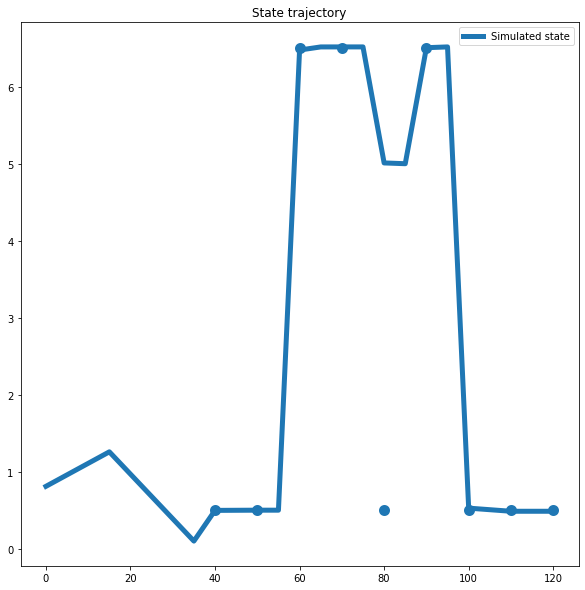

In [16]:
x_ = collect_x(results[PERIODS_RESULTS])
sx_ = collect_sx(results[PERIODS_RESULTS])
t_ = collect_t(results[PERIODS_RESULTS])

T, X, SX = remove_duplicates(t_, x_, sx_)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(T, X, lw=5, label='Simulated state')
ax.legend()
ax.set_title('State trajectory')

mT = control_problem.simulator.petab_problem.measurement_df[TIME]
mX = control_problem.simulator.petab_problem.measurement_df[MEASUREMENT]

#ax.set_yscale('log')

ax.scatter(mT, mX, lw=5, label='Measured state')

In [17]:
from petab_timecourse.amici import add_output_timepoints_if_missing
if True:
    # Fake timepoints for more simulation output
    for edata, period in zip(
        control_problem.simulator.amici_edata_periods,
        control_problem.simulator.timecourse.periods,
    ):
        current_timepoints = edata.getTimepoints()
        add_output_timepoints_if_missing(
            amici_edata=edata,
            timepoints=np.linspace(current_timepoints[0], current_timepoints[-1], 101)
        )

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(



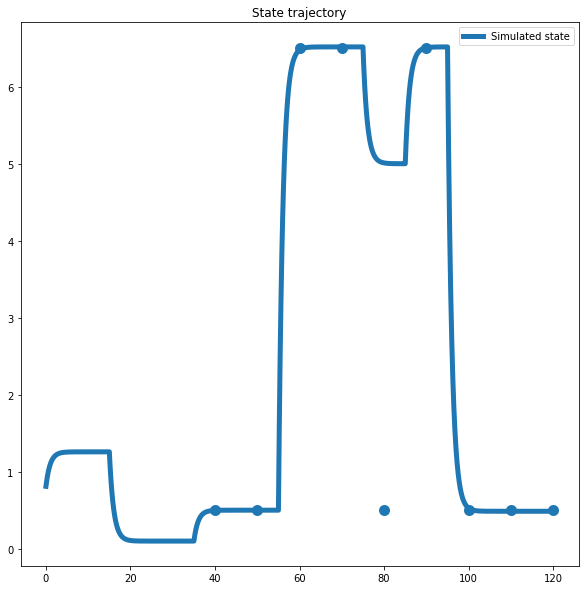

In [18]:
results = control_problem.simulate(problem_parameters=problem_parameters)

x_ = collect_x(results[PERIODS_RESULTS])
sx_ = collect_sx(results[PERIODS_RESULTS])
t_ = collect_t(results[PERIODS_RESULTS])

T, X, SX = remove_duplicates(t_, x_, sx_)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(T, X, lw=5, label='Simulated state')
ax.legend()
ax.set_title('State trajectory')

mT = control_problem.simulator.petab_problem.measurement_df[TIME]
mX = control_problem.simulator.petab_problem.measurement_df[MEASUREMENT]

#ax.set_yscale('log')

ax.scatter(mT, mX, lw=5, label='Measured state')